In [45]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
import pandas as pd
from collections import defaultdict

In [2]:
ds = xr.open_mfdataset(
    ['arome__001__SP1__01H__2024-08-22T06_00_00Z.grib2'], 
     #'arome__001__SP1__01H__2024-08-22T06_00_00Z.grib2', 
     #'arome__001__SP1__02H__2024-08-22T06_00_00Z.grib2',
     #'arome__001__SP1__03H__2024-08-22T06_00_00Z.grib2'],
    combine='by_coords',
    engine='cfgrib',
    backend_kwargs={
        'filter_by_keys': {
            'typeOfLevel': 'heightAboveGround',
            'level': 2  # or 10 depending on what you want
        }
    }
)

In [30]:
file_list = ['arome_data/arome__001__SP1__00H__2024-08-22T06_00_00Z.grib2', 
             'arome_data/arome__001__SP1__01H__2024-08-22T06_00_00Z.grib2', 
             'arome_data/arome__001__SP1__02H__2024-08-22T06_00_00Z.grib2',
             'arome_data/arome__001__SP1__03H__2024-08-22T06_00_00Z.grib2']
backend_kwargs = {
    'filter_by_keys': {
        'typeOfLevel': 'heightAboveGround',
        'level': 2
    }
}
datasets = [xr.open_dataset(f, engine='cfgrib', backend_kwargs=backend_kwargs) for f in file_list]
ds = xr.concat(datasets, dim='step')

In [8]:
ds['t2m'] = ds['t2m'] - 273.15

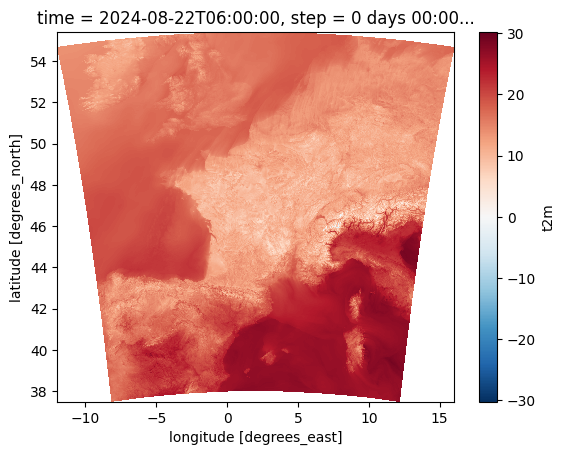

In [9]:
ds.t2m[0].plot()

In [10]:
dsf = ds.to_dataframe()
dsf = dsf.reset_index()
dsf_lat_lon = dsf[['latitude', 'longitude']].values.tolist()
len(dsf_lat_lon)

20066364

In [78]:
geo_dep = gpd.read_file('geojsonfrance.json')
geo_dep = geo_dep.rename(columns={'code': 'Dep'})
gdf = gpd.read_file('france.json')
geo_dep

,Dep,nom,geometry
0,02,Aisne,"POLYGON ((3.1727 50.012, 3.1822 50.01234, 3.21..."
1,10,Aube,"POLYGON ((3.41479 48.39027, 3.42208 48.41334, ..."
2,14,Calvados,"POLYGON ((-1.11962 49.35557, -1.11503 49.3624,..."
3,15,Cantal,"POLYGON ((2.50841 45.4785, 2.52444 45.4807, 2...."
4,28,Eure-et-Loir,"POLYGON ((0.81482 48.67016, 0.82767 48.68072, ..."
...,...,...,...
91,41,Loir-et-Cher,"POLYGON ((0.84122 48.10306, 0.87588 48.10943, ..."
92,53,Mayenne,"POLYGON ((-0.86036 48.50146, -0.84611 48.49828..."
93,54,Meurthe-et-Moselle,"MULTIPOLYGON (((5.45556 49.48093, 5.44953 49.4..."
94,79,Deux-Sèvres,"POLYGON ((-0.89196 46.97582, -0.87973 46.9758,..."


In [12]:
minx, miny, maxx, maxy = gdf.total_bounds.round(2)
print(minx, miny, maxx, maxy)
resolution = 0.01
x_coords = np.arange(minx, maxx, resolution)
y_coords = np.arange(miny, maxy, resolution)
grid_points = [[round(x, 2), round(y, 2)] for x in x_coords for y in y_coords]
len(grid_points)

-4.59 41.38 9.56 51.15


1382455

In [13]:
df = pd.DataFrame(grid_points, columns=['longitude', 'latitude'])
df.to_csv('france_coords.csv')

In [15]:
lat_lon = pd.read_csv('france_coords.csv')[['longitude', 'latitude']]
dsf['latitude'] = round(dsf['latitude'], 2)
dsf['longitude'] = round(dsf['longitude'], 2)

dsf_france = pd.merge(dsf, lat_lon, on=['latitude', 'longitude'], how='inner')
dsf_france

,step,latitude,longitude,t2m,r2,time,heightAboveGround,valid_time
0,0 days 00:00:00,51.14,-4.59,17.183807,95.127502,2024-08-22 06:00:00,2.0,2024-08-22 06:00:00
1,0 days 00:00:00,51.14,-4.58,17.186737,95.127502,2024-08-22 06:00:00,2.0,2024-08-22 06:00:00
2,0 days 00:00:00,51.14,-4.57,17.191620,95.127502,2024-08-22 06:00:00,2.0,2024-08-22 06:00:00
3,0 days 00:00:00,51.14,-4.56,17.191620,95.221252,2024-08-22 06:00:00,2.0,2024-08-22 06:00:00
4,0 days 00:00:00,51.14,-4.55,17.185760,95.346252,2024-08-22 06:00:00,2.0,2024-08-22 06:00:00
...,...,...,...,...,...,...,...,...
5529815,0 days 03:00:00,41.38,9.51,25.981720,76.718987,2024-08-22 06:00:00,2.0,2024-08-22 09:00:00
5529816,0 days 03:00:00,41.38,9.52,25.992462,76.718987,2024-08-22 06:00:00,2.0,2024-08-22 09:00:00
5529817,0 days 03:00:00,41.38,9.53,25.996368,76.812737,2024-08-22 06:00:00,2.0,2024-08-22 09:00:00
5529818,0 days 03:00:00,41.38,9.54,26.000275,76.906487,2024-08-22 06:00:00,2.0,2024-08-22 09:00:00


In [24]:
mean_dsf_france = dsf_france.groupby(['latitude', 'longitude']).mean().reset_index()[['latitude', 'longitude', 't2m']]
mean_dsf_france

,latitude,longitude,t2m
0,41.38,-4.59,20.640282
1,41.38,-4.58,20.798729
2,41.38,-4.57,20.941307
3,41.38,-4.56,21.032127
4,41.38,-4.55,21.115379
...,...,...,...
1382450,51.14,9.51,15.397362
1382451,51.14,9.52,15.430809
1382452,51.14,9.53,15.646629
1382453,51.14,9.54,15.867088


In [26]:
ds = mean_dsf_france.set_index(['latitude', 'longitude']).to_xarray()

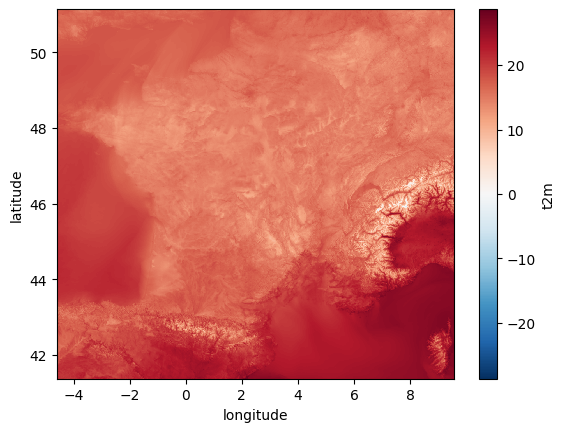

In [28]:
ds.t2m.plot()

In [55]:
df_dep = pd.read_csv('points-extremes-des-departements-metropolitains-de-france.csv')
df_dep = df_dep.rename(columns={'Departement': 'Dep',
                                'Latitude la plus au nord': 'LatMax',
                                'Latitude la plus au sud': 'LatMin',
                                'Longitude la plus à l’est': 'LongMax', 
                                'Longitude la plus à l’ouest': 'LongMin'})
df_dep = round(df_dep, 2)

In [56]:
lst = []
resolution = 0.01
for i, row in df_dep.iterrows():
    x_coords = np.arange(row['LongMin'], row['LongMax'], resolution)
    y_coords = np.arange(row['LatMin'], row['LatMax'], resolution)
    grid_points = [[round(x, 2), round(y, 2)] for x in x_coords for y in y_coords]
    lst.append(pd.DataFrame(grid_points, columns=['longitude', 'latitude']))
df_dep['grid_points'] = lst

In [79]:
df_dep = pd.merge(df_dep, geo_dep, on='Dep', how='inner')
df_dep

,Dep,LatMax,LatMin,LongMax,LongMin,grid_points,nom,geometry
0,01,46.52,45.61,6.17,4.73,longitude latitude 0 4.73 ...,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,50.07,48.84,4.25,2.96,longitude latitude 0 2.96 ...,Aisne,"POLYGON ((3.1727 50.012, 3.1822 50.01234, 3.21..."
2,03,46.80,45.93,4.01,2.28,longitude latitude 0 2.28 ...,Allier,"POLYGON ((3.03206 46.79491, 3.03684 46.7844, 3..."
3,04,44.66,43.67,6.97,5.50,longitude latitude 0 5.50 ...,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ..."
4,05,45.13,44.19,7.08,5.42,longitude latitude 0 5.42 ...,Hautes-Alpes,"POLYGON ((6.26057 45.12684, 6.2755 45.1153, 6...."
...,...,...,...,...,...,...,...,...
91,93,49.01,48.81,2.60,2.29,longitude latitude 0 2.29 48...,Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.56579 49.0124, 2..."
92,94,48.86,48.69,2.61,2.31,longitude latitude 0 2.31 48...,Val-de-Marne,"POLYGON ((2.3319 48.81701, 2.36395 48.81631, 2..."
93,95,49.23,48.91,2.59,1.61,longitude latitude 0 1.61 ...,Val-d'Oise,"POLYGON ((1.70436 49.2322, 1.72966 49.2292, 1...."
94,2A,42.38,41.36,9.41,8.54,longitude latitude 0 8.54 ...,Corse-du-Sud,"MULTIPOLYGON (((9.27103 41.36496, 9.2657 41.36..."


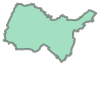

In [80]:
df_dep['geometry'][0]